In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader


# Data Analysis

We begin by loading the dataset and examining its distribution.

In [ ]:
# Dataset loading
col_names = ['ID', 'label', 'statement', 'subject', 'speaker', 'speaker\'s title', 'state', 'party', 'barely true', 'false', 'half true', 'mostly true', 'pants on fire', 'context', 'justification']
train_df = pd.read_csv('data/train2.tsv', sep='\t', names=col_names)
test_df = pd.read_csv('data/test2.tsv', sep='\t', names=col_names)
val_df = pd.read_csv('data/val2.tsv', sep='\t', names=col_names)

train_df = train_df.fillna(0)
test_df = test_df.fillna(0)
val_df = val_df.fillna(0)

In [3]:
train_df.head()

,ID,label,statement,subject,speaker,speaker's title,state,party,barely true,false,half true,mostly true,pants on fire,context,justification
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,0,0,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,0,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [4]:
train_df['label'].value_counts()

,count
label,
half-true,2114
false,1995
mostly-true,1962
true,1676
barely-true,1654
pants-fire,839


In [5]:
print(f'Number of datapoints are {len(train_df)}')
print(f'Shape of df is {train_df.shape}')
train_df.info()

Number of datapoints are 10240
Shape of df is (10240, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10240 non-null  object 
 1   label            10240 non-null  object 
 2   statement        10240 non-null  object 
 3   subject          10240 non-null  object 
 4   speaker          10240 non-null  object 
 5   speaker's title  10240 non-null  object 
 6   state            10240 non-null  object 
 7   party            10240 non-null  object 
 8   barely true      10240 non-null  float64
 9   false            10240 non-null  float64
 10  half true        10240 non-null  float64
 11  mostly true      10240 non-null  float64
 12  pants on fire    10240 non-null  float64
 13  context          10240 non-null  object 
 14  justification    10240 non-null  object 
dtypes: float64(5), object(10)
memory usage: 1.2+ M

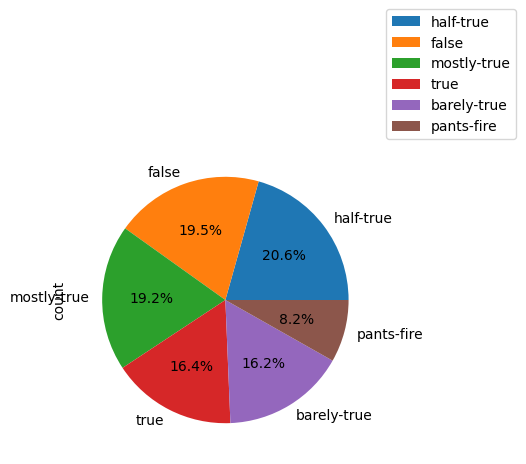

In [6]:
train_df["label"].value_counts().head(7).plot(kind = 'pie', autopct='%1.1f%%', figsize=(4, 4)).legend(bbox_to_anchor=(1, 1))

Overall, the class labels appear relatively balanced, with the exception of the "Pants on Fire" category, which is underrepresented compared to the others.

# Data Preparation

We prepare the textual data before training the model.
The preprocessing step involves cleaning the text.
Afterwards, the original labels (true, half-true, pants-fire, etc.) are
encoded into a binary format, distinguishing between "True" and "False".
Finally, we explore the distribution of labels in the training set through
visualizations to check for potential class imbalance.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case=True, use_auth_token=None)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
# Encoding labels
def encode_labels(df):
    df['label'] = df['label'].map({
        'true': 1, 'mostly-true': 1, 'half-true': 1,
        'false': 0, 'barely-true': 0, 'pants-fire': 0
    })
    return df

train_df = encode_labels(train_df)
val_df = encode_labels(val_df)
test_df = encode_labels(test_df)

In [9]:
label_counts = train_df['label'].value_counts()

print("Label distribution in the Train set:")
print(f"False: {label_counts.get(0, 0)} example")
print(f"True: {label_counts.get(1, 0)} example")


Label distribution in the Train set:
False: 4488 example
True: 5752 example


The dataset is not perfectly balanced, because the True class represents about 56% of the examples while the False class represents about 44%.

## Metadata combination
In this step, in addition to the main statement, the metadata associated with each example—such as the subject, speaker, role, state, party, and context, are incorporated. This approach allows the model to access not only the textual content of the statement but also contextual information, which can be useful for better classifying the veracity of the claim.

In [10]:
# Combine text e metadata
def combine_text_and_metadata(df):
    meta = []
    for i in range(len(df)):
        subject = df['subject'][i] if df['subject'][i] != 0 else 'None'
        speaker = df['speaker'][i] if df['speaker'][i] != 0 else 'None'
        job = df["speaker's title"][i] if df["speaker's title"][i] != 0 else 'None'
        state = df['state'][i] if df['state'][i] != 0 else 'None'
        party = df['party'][i] if df['party'][i] != 0 else 'None'
        context = df['context'][i] if df['context'][i] != 0 else 'None'
        meta_text = f"{subject} {speaker} {job} {state} {party} {context}"
        meta.append(meta_text)
    df['combined_text'] = df['statement'].astype(str) + " " + pd.Series(meta)
    return df


In [11]:
train_df = combine_text_and_metadata(train_df)
val_df = combine_text_and_metadata(val_df)
test_df = combine_text_and_metadata(test_df)


# Data Cleaning and Tokenization


We prepare the textual data before training the model.
The preprocessing step involves cleaning the text.

In [12]:
# Pre-processing
def preprocess_text(texts):
    processed = []
    for text in texts:
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        processed.append(text.strip())
    return processed

In [13]:
# Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', do_lower_case=True)

def tokenize_data(df, tokenizer, max_len=256):
    texts = preprocess_text(df['combined_text'])
    encodings = tokenizer.batch_encode_plus(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encodings

train_encodings = tokenize_data(train_df, tokenizer)
val_encodings = tokenize_data(val_df, tokenizer)
test_encodings = tokenize_data(test_df, tokenizer)

In [14]:
# Creation dataset
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(train_df['label'].values).long()
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(val_df['label'].values).long()
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(test_df['label'].values).long()
)

# Architecture

The architecture consists of two main parts:
1. first, the pre-trained DistilBERT encodes input text into contextual embeddings;
2. second, a multi-layer perceptron (MLP) classifier takes the pooled embeddings and predicts whether a statement is True or False.

The model applies mean pooling over the token embeddings to obtain a single vector representation for each input, effectively summarizing the information while ignoring padding tokens.
Additionally, the MLP layers include GELU activations and dropout to improve model expressiveness and prevent overfitting, with all linear layers initialized using Xavier normalization for stable training.

In [15]:
import torch
import torch.nn as nn
from transformers import DistilBertModel
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

In [16]:
# Define the model: DistilBERT + MLP (Multi-Layer Perceptron)
class DistilBERTMLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the pre-trained DistilBERT model
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Define the MLP classifier on top of DistilBERT's output
        self.mlp = nn.Sequential(
            nn.Linear(768, 512),
            nn.GELU(),             # GELU activation function
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.4),

            nn.Linear(256, 64),
            nn.GELU(),
            nn.Dropout(0.4),

            nn.Linear(64, 2)
        )

        # Initialize weights of the MLP
        self._init_weights()

    # Function to initialize the MLP weights
    def _init_weights(self):
        for layer in self.mlp:
            if isinstance(layer, nn.Linear):
                # Xavier normal initialization for weights
                nn.init.xavier_normal_(layer.weight)
                # Initialize bias to 0
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    # Forward pass
    def forward(self, input_ids, attention_mask):
        # Pass through DistilBERT
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state

        # Mean pooling over all tokens
        mask = attention_mask.unsqueeze(-1)
        masked_hidden = last_hidden_state * mask
        pooled = masked_hidden.sum(dim=1) / mask.sum(dim=1)

        # Pass the pooled output through the MLP for classification
        return self.mlp(pooled)


In [17]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


We specify the main hyperparameters (batch size, number of epochs, weight decay, and warmup steps).

Then, class weights are computed using the inverse of class frequency to address the mild imbalance in the dataset. Since the model could otherwise be biased toward the more frequent class(True), assigning higher weights to underrepresented classes(False) ensures that errors on these samples contribute more significantly to the loss. This approach encourages the model to pay attention to all classes during training, improving its ability to correctly classify minority examples without needing to oversample or undersample the data.

DataLoaders are created for training, validation, and testing.

In [18]:
# Configuration training
BATCH_SIZE = 16
EPOCHS = 6
WEIGHT_DECAY = 0.05
WARMUP_STEPS = 100

# Compute class weights based on label distribution
class_counts = train_df['label'].value_counts().sort_index() # Count the number of samples per class
# Inverse frequency == less represented classes receive higher weights
class_weights = torch.tensor((1. / class_counts).values, dtype=torch.float32).to(device)


In [19]:
# Dataloaders
from torch.utils.data import RandomSampler, SequentialSampler

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=BATCH_SIZE
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=BATCH_SIZE
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=BATCH_SIZE
)


# Inizializzazione modello
model = DistilBERTMLPClassifier().to(device)

We implement a gradual unfreezing strategy during fine-tuning, adapting DistilBERT incrementally.

The idea is to first train only the higher layers (the MLP and the top DistilBERT layers), which are closest to the final task, and then progressively unfreeze the deeper layers. This approach allows the model to preserve the general knowledge learned during pre-training while gradually adapting to the specific task.

As a result, weight updates are more stable and controlled, reducing the risk of overfitting, and enabling the model to classify statements as true or false even with limited and slightly imbalanced data.

In [20]:
# Gradual unfreezing strategy
def set_requires_grad(model, epoch):
    # Phase 0: only train the MLP classifier
    if epoch == 0:
        for param in model.distilbert.parameters():
            param.requires_grad = False   # Freeze all DistilBERT parameters
        for param in model.mlp.parameters():
            param.requires_grad = True    # Train only the MLP head

    # Phase 1: unfreeze layer 5
    elif epoch == 1:
        for param in model.distilbert.transformer.layer[5].parameters():
            param.requires_grad = True    # Unfreeze the last transformer layer
        for param in model.distilbert.transformer.layer[:5].parameters():
            param.requires_grad = False   # Keep the other layers frozen
        for param in model.mlp.parameters():
            param.requires_grad = True    # Keep training the MLP head

    # Phase 2: unfreeze layer 4
    elif epoch == 2:
        for param in model.distilbert.transformer.layer[4].parameters():
            param.requires_grad = True    # Unfreeze the second-to-last transformer layer
        for param in model.distilbert.transformer.layer[:4].parameters():
            param.requires_grad = False   # Keep lower layers frozen (0–3)
        for param in model.mlp.parameters():
            param.requires_grad = True

    # Phase 3: unfreeze layer 3
    elif epoch == 3:
        for param in model.distilbert.transformer.layer[3].parameters():
            param.requires_grad = True    # Unfreeze layer 3
        for param in model.distilbert.transformer.layer[:3].parameters():
            param.requires_grad = False   # Keep the first 3 layers frozen
        for param in model.mlp.parameters():
            param.requires_grad = True

    # Phase 4+: unfreeze everything
    else:
        for param in model.parameters():
            param.requires_grad = True    # Train the entire model



The optimizer, learning rate scheduler, and loss function are configured for fine-tuning the model. The AdamW optimizer assigns different learning rates to various DistilBERT layers and the MLP classifier, allowing the deeper layers to adapt slowly while the task-specific layers update more quickly.

The learning rate scheduler uses cosine annealing with periodic restarts to stabilize and improve convergence during training. Finally, the weighted Cross-Entropy loss accounts for class imbalance, giving more importance to underrepresented examples and ensuring more balanced learning.

In [21]:
# Optimizer with layer-wise learning rates
optimizer = AdamW([
    # Layers 0-1 of DistilBERT: very small learning rate for stable fine-tuning
    {'params': [p for n, p in model.distilbert.named_parameters() if "layer.0" in n or "layer.1" in n], 'lr': 1e-5},
    # Layers 2-3: slightly higher learning rate
    {'params': [p for n, p in model.distilbert.named_parameters() if "layer.2" in n or "layer.3" in n], 'lr': 1.5e-5},
    # Layers 4-5: higher learning rate, closer to task-specific adaptation
    {'params': [p for n, p in model.distilbert.named_parameters() if "layer.4" in n or "layer.5" in n], 'lr': 2e-5},
    # MLP classifier: highest learning rate as it is trained from scratch
    {'params': model.mlp.parameters(), 'lr': 2e-5}
], weight_decay=WEIGHT_DECAY, eps=1e-8)

# Cosine annealing scheduler with warm restarts
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=1)

# Weighted cross-entropy loss
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
# Training loop 
from sklearn.metrics import f1_score, roc_auc_score
import copy

# 9. Training loop
def train_model():
    best_val_accuracy = 0
    best_model_state = None
    early_stop_counter = 0
    PATIENCE = 3
    training_stats = []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        print("-" * 50)
        set_requires_grad(model, epoch)
        model.train()
        total_train_loss, total_train_correct = 0, 0

        for step, batch in enumerate(train_dataloader):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            model.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step(epoch + step / len(train_dataloader))

            total_train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            total_train_correct += (preds == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = total_train_correct / len(train_dataset)

        # Validation
        model.eval()
        total_val_loss, total_val_correct = 0, 0
        all_preds, all_labels = [], []

        for batch in val_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            with torch.no_grad():
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                total_val_correct += (preds == labels).sum().item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = total_val_correct / len(val_dataset)
        val_f1 = f1_score(all_labels, all_preds)
        val_roc_auc = roc_auc_score(all_labels, all_preds)

        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_acc': train_accuracy,
            'val_loss': avg_val_loss,
            'val_acc': val_accuracy,
            'val_f1': val_f1,
            'val_roc_auc': val_roc_auc
        })

        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            early_stop_counter += 1
            if early_stop_counter >= PATIENCE:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    model.load_state_dict(best_model_state)
    return model, training_stats

In [ ]:
trained_model, stats = train_model()


Epoch 1/6
--------------------------------------------------
Train Loss: 0.6967, Train Acc: 0.5146
Val Loss: 0.6845, Val Acc: 0.5880, Val F1: 0.6765, Val ROC-AUC: 0.5779

Epoch 2/6
--------------------------------------------------
Train Loss: 0.6853, Train Acc: 0.5437
Val Loss: 0.6778, Val Acc: 0.6075, Val F1: 0.6500, Val ROC-AUC: 0.6035

Epoch 3/6
--------------------------------------------------
Train Loss: 0.6688, Train Acc: 0.5912
Val Loss: 0.6483, Val Acc: 0.6199, Val F1: 0.6121, Val ROC-AUC: 0.6218

Epoch 4/6
--------------------------------------------------
Train Loss: 0.6510, Train Acc: 0.6192
Val Loss: 0.6458, Val Acc: 0.6363, Val F1: 0.6405, Val ROC-AUC: 0.6369

Epoch 5/6
--------------------------------------------------
Train Loss: 0.6438, Train Acc: 0.6308
Val Loss: 0.6242, Val Acc: 0.6542, Val F1: 0.6547, Val ROC-AUC: 0.6552

Epoch 6/6
--------------------------------------------------
Train Loss: 0.5904, Train Acc: 0.6834
Val Loss: 0.6268, Val Acc: 0.6581, Val F1: 0.

We have progressive learning, with improvement in both train and validation accuracy, and does not show marked overfitting. The F1 and ROC-AUC metrics indicate that the model is improving in discrimination between classes.

# Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score

def evaluate_metrics(model, dataloader, device):
    model.eval()
    total_correct = 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids, attention_mask)

            # Probabilità per la classe positiva
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1)

            total_correct += (preds == labels).sum().item()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    accuracy = total_correct / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, digits=4)

    print(f"Test Accuracy: {accuracy:.4f}, Test F1: {f1:.4f}, Test ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)

    return accuracy, f1, roc_auc, all_labels, all_probs

test_accuracy, test_f1, test_roc_auc, all_labels, all_probs = evaluate_metrics(trained_model, test_dataloader, device)

Test Accuracy: 0.6630, Test F1: 0.6987, Test ROC-AUC: 0.7092
Confusion Matrix:
 [[345 208]
 [219 495]]
Classification Report:
               precision    recall  f1-score   support

           0     0.6117    0.6239    0.6177       553
           1     0.7041    0.6933    0.6987       714

    accuracy                         0.6630      1267
   macro avg     0.6579    0.6586    0.6582      1267
weighted avg     0.6638    0.6630    0.6633      1267



The model is balanced and stable, with good overall performance. The minority class (False) remains harder to recognize, but the F1-score still indicates decent discrimination.

We plot the ROC curve to evaluate the model's ability to discriminate between True and False classes.

In [25]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(all_labels, all_probs, roc_auc):
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6,6))

    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


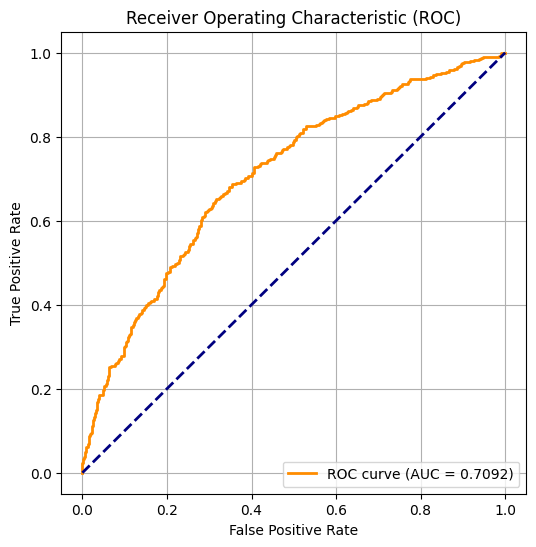

In [26]:
plot_roc_curve(all_labels, all_probs, test_roc_auc)

## Sample Prediction Analysis
To better understand how the model works, let's select some examples from the test set and compare the predictions with real labels. For each example we report the predicted class and the associated probabilities, so as to see both the cases in which the model guesses and those in which it makes mistakes.
This allows us to directly observe how the model handles ambiguous statements and how confident it is in its predictions.

In [27]:
def predict_sample(model, tokenizer, text, device):
    model.eval()
    encodings = tokenizer.encode_plus(
        text,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        return predicted_class, probs.squeeze().cpu().numpy()

# Get some sample texts from the test set
sample_indices = [0, 5, 10, 15, 20]
sample_texts = test_df.iloc[sample_indices]['combined_text'].tolist()
sample_labels = test_df.iloc[sample_indices]['label'].tolist()

print("Sample Predictions:")
for i, text in enumerate(sample_texts):
    predicted_label, probabilities = predict_sample(trained_model, tokenizer, text, device)
    print(f"Text: {text[:100]}...")
    print(f"Actual Label: {sample_labels[i]}, Predicted Label: {predicted_label}, Probabilities: {probabilities}")
    print("-" * 20)

Sample Predictions:
Text: Building a wall on the U.S.-Mexico border will take literally years. immigration rick-perry Governor...
Actual Label: 1, Predicted Label: 0, Probabilities: [0.78078926 0.21921071]
--------------------
Text: Over the past five years the federal government has paid out $601 million in retirement and disabili...
Actual Label: 1, Predicted Label: 1, Probabilities: [0.37130848 0.6286915 ]
--------------------
Text: We know there are more Democrats in Georgia than Republicans. We know that for a fact. elections mik...
Actual Label: 0, Predicted Label: 1, Probabilities: [0.27737668 0.7226233 ]
--------------------
Text: Says the unemployment rate for college graduates is 4.4 percent and over 10 percent for noncollege-e...
Actual Label: 1, Predicted Label: 1, Probabilities: [0.19836557 0.80163443]
--------------------
Text: There have not been any public safety issues in cities that allow transgender people to use the bath...
Actual Label: 1, Predicted Label: 0, Proba